In [1]:
from zipfile import ZipFile
import pandas as pd
import os, time
import shutil
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
from tqdm.notebook import tqdm, trange
import loader
import data
import onnxruntime

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import cv2

2022-11-13 11:23:28.841829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/data/awong189/miniconda/envs/thesis/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pano_path = "/data3/awong/pano/M3D_low/"
test = loader.generate_dataframe("./splits/M3D_v1_test.yaml", pano_path)
test_generator = data.DataGenerator(
            test, batch_size=32, shuffle=False, wrap=64
)

In [19]:
def abs_rel_err(pred, expected):
    return np.mean(np.divide(np.abs(pred - expected), expected))

def sq_rel_err(pred, expected):
    return np.mean(np.divide(np.square(pred - expected), expected))

def root_mean_sq_err(pred, expected):
#     return np.sqrt(np.mean((pred-expected)**2))
    return np.sqrt(np.square(np.subtract(y_actual,y_predicted)).mean())

def root_mean_sq_err_log(pred, expected):
    return np.sqrt(np.mean((np.log2(pred)-np.log2(expected))**2))

# https://github.com/nianticlabs/monodepth2/blob/master/evaluate_depth.py
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    # prevent divide by 0
    gt += 1e-7
    pred += 1e-7
    
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = np.sqrt(np.square(np.subtract(gt,pred)).mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())
    
    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

def calculate_errors(model, test_gen):
    absrel = 0
    sqrel = 0
    rmse = 0
    rmse_log = 0
    a1 = 0
    a2 = 0
    a3 = 0
    
    num = len(test_gen.images)
    
    for i in trange(len(test_gen)):
        img, depths = test_gen[i]
        preds = model.predict(img)

        for p, d in zip(preds, depths):
            ab, sq, rm, rm_log, _a1, _a2, _a3 = compute_errors(d, p)
            absrel += ab
            sqrel += sq
            rmse += rm
            rmse_log += rm_log
            a1 += _a1
            a2 += _a2
            a3 += _a3
        
    print("Abs Rel: %0.2f | Sq Rel: %0.2f | RMSE: %0.2f | RMSE log: %0.2f | a1: %0.2f | a2: %0.2f | a3: %0.2f" % (absrel / num, sqrel / num, rmse / num, rmse_log / num, a1 / num, a2 / num, a3 / num))
    return absrel, sqrel, rmse, rmse_log, a1, a2, a3

def calculate_errors_onnx(sess, test_gen):
    absrel = 0
    sqrel = 0
    rmse = 0
    rmse_log = 0
    a1 = 0
    a2 = 0
    a3 = 0
    
    num = len(test_gen.images)
    inputs = sess.get_inputs()[0].name
    output = sess.get_outputs()[0].name
    
#     print(inputs, output, sess.get_outputs()[0].shape)
    
    for i in trange(len(test_gen)):
        img, depths = test_gen[i]
        preds = sess.run([output], {inputs: img})[0]
#         print(img[0].shape, depths[0].shape, preds[0].shape)

        for p, d in zip(preds, depths):
#             print(p.shape, d.shape)
            ab, sq, rm, rm_log, _a1, _a2, _a3 = compute_errors(d, p)
            absrel += ab
            sqrel += sq
            rmse += rm
            rmse_log += rm_log
            a1 += _a1
            a2 += _a2
            a3 += _a3
            
        
    print("Abs Rel: %0.2f | Sq Rel: %0.2f | RMSE: %0.2f | RMSE log: %0.2f | a1: %0.2f | a2: %0.2f | a3: %0.2f" % (absrel / num, sqrel / num, rmse / num, rmse_log / num, a1 / num, a2 / num, a3 / num))
    return absrel, sqrel, rmse, rmse_log, a1, a2, a3

In [4]:
from utils import new_new_loss, loss_function
keras.backend.clear_session()

custom_func = {"new_new_loss": new_new_loss, "loss_function": loss_function}
model = tf.keras.models.load_model('./mobile_scene_skip_loss_1.h5', custom_objects=custom_func)
model.summary()

/data/awong189/miniconda/envs/thesis/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-11-13 02:18:47.089580: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-13 02:18:47.090667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 640, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 320, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 320, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 320, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [5]:
calculate_errors(model, test_generator)

  0%|          | 0/190 [00:00<?, ?it/s]

2022-11-13 02:18:50.983128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-13 02:18:50.984022: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1995935000 Hz
2022-11-13 02:18:51.658693: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-13 02:18:51.849738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-13 02:18:52.938023: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-13 02:18:53.048352: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Abs Rel: 6.59 | Sq Rel: 0.75 | RMSE: 0.08 | RMSE log: 0.47 | a1: 0.56 | a2: 0.80 | a3: 0.89


(10055.549076378345,
 1144.4987429366447,
 116.61087655462325,
 717.6490829885006,
 855.9894409179693,
 1218.9832153320317,
 1361.1073425292957)

In [79]:
import glob

for name in glob.glob('./result/*.h5'):
    keras.backend.clear_session()

    custom_func = {"new_new_loss": new_new_loss, "loss_function": loss_function}
    model = tf.keras.models.load_model(name, custom_objects=custom_func)
    print(name)
    calculate_errors(model, test_generator)

./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.27 | Sq Rel: 2.21 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 13.54 | Sq Rel: 1.54 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_all_3.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.18 | Sq Rel: 1.76 | RMSE: 0.11 | RMSE log: 0.66 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.29 | Sq Rel: 1.88 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_all_0.5_0.1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.11 | Sq Rel: 1.74 | RMSE: 0.11 | RMSE log: 0.66 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_edges_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.58 | Sq Rel: 2.13 | RMSE: 0.11 | RMSE log: 0.69 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_berhu_edges_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 19.85 | Sq Rel: 2.26 | RMSE: 0.13 | RMSE log: 0.80 | a1: 0.36 | a2: 0.59 | a3: 0.73
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_sobel_edges_2.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.87 | Sq Rel: 2.13 | RMSE: 0.12 | RMSE log: 0.66 | a1: 0.42 | a2: 0.66 | a3: 0.79
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_berhu.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 17.66 | Sq Rel: 2.63 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_all_0.1_0.5.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.06 | Sq Rel: 1.85 | RMSE: 0.11 | RMSE log: 0.68 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 17.00 | Sq Rel: 2.38 | RMSE: 0.11 | RMSE log: 0.71 | a1: 0.39 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_berhu.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 18.53 | Sq Rel: 2.37 | RMSE: 0.11 | RMSE log: 0.73 | a1: 0.39 | a2: 0.62 | a3: 0.76
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth_berhu.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.27 | Sq Rel: 1.81 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.25 | Sq Rel: 1.56 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_berhu_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.98 | Sq Rel: 2.26 | RMSE: 0.12 | RMSE log: 0.70 | a1: 0.38 | a2: 0.63 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_sobel_edges_1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 15.20 | Sq Rel: 1.97 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.41 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 17.09 | Sq Rel: 2.31 | RMSE: 0.11 | RMSE log: 0.68 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.00 | Sq Rel: 1.54 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_sobel_3.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 19.42 | Sq Rel: 2.17 | RMSE: 0.13 | RMSE log: 0.75 | a1: 0.34 | a2: 0.59 | a3: 0.73
./result/shuffle_pano_skip_scene_sigmoid_sobel_1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 20.00 | Sq Rel: 2.28 | RMSE: 0.13 | RMSE log: 0.80 | a1: 0.36 | a2: 0.59 | a3: 0.73
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 17.32 | Sq Rel: 2.63 | RMSE: 0.11 | RMSE log: 0.68 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth_berhu_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 15.89 | Sq Rel: 2.14 | RMSE: 0.11 | RMSE log: 0.69 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_all_0.3_2.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.87 | Sq Rel: 1.99 | RMSE: 0.11 | RMSE log: 0.67 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 261.18 | Sq Rel: 260.38 | RMSE: 0.82 | RMSE log: 2.31 | a1: 0.03 | a2: 0.05 | a3: 0.07
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 19.32 | Sq Rel: 2.68 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_sobel_1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.97 | Sq Rel: 1.80 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.39 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 15.52 | Sq Rel: 2.00 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 19.65 | Sq Rel: 2.29 | RMSE: 0.13 | RMSE log: 0.73 | a1: 0.36 | a2: 0.60 | a3: 0.74
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.50 | Sq Rel: 1.94 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_all_1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.40 | Sq Rel: 2.27 | RMSE: 0.12 | RMSE log: 0.66 | a1: 0.42 | a2: 0.66 | a3: 0.79
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.54 | Sq Rel: 2.20 | RMSE: 0.11 | RMSE log: 0.68 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_all_0.1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 15.54 | Sq Rel: 2.00 | RMSE: 0.11 | RMSE log: 0.66 | a1: 0.41 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_smooth.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 264.30 | Sq Rel: 263.51 | RMSE: 0.82 | RMSE log: 2.31 | a1: 0.03 | a2: 0.04 | a3: 0.07
./result/shuffle_pano_skip_scene_sigmoid_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.97 | Sq Rel: 2.21 | RMSE: 0.11 | RMSE log: 0.71 | a1: 0.39 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth__berhu_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.55 | Sq Rel: 2.08 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth_berhu_edges_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.69 | Sq Rel: 2.02 | RMSE: 0.11 | RMSE log: 0.69 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_berhu_sobel_edges_3.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.98 | Sq Rel: 2.22 | RMSE: 0.12 | RMSE log: 0.66 | a1: 0.42 | a2: 0.66 | a3: 0.79
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 14.76 | Sq Rel: 2.01 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.40 | a2: 0.65 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_sobel_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 13.18 | Sq Rel: 1.42 | RMSE: 0.12 | RMSE log: 0.68 | a1: 0.39 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_l1.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.79 | Sq Rel: 2.35 | RMSE: 0.11 | RMSE log: 0.71 | a1: 0.39 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_berhu.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 17.25 | Sq Rel: 2.66 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.40 | a2: 0.64 | a3: 0.77
./result/shuffle_pano_skip_scene_sigmoid_ssim_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.81 | Sq Rel: 1.90 | RMSE: 0.12 | RMSE log: 0.69 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_smooth_sobel.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 16.65 | Sq Rel: 2.15 | RMSE: 0.11 | RMSE log: 0.69 | a1: 0.40 | a2: 0.64 | a3: 0.78
./result/shuffle_pano_skip_scene_sigmoid_ssim_l1_smooth_berhu_edges.h5


  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 15.43 | Sq Rel: 2.28 | RMSE: 0.11 | RMSE log: 0.69 | a1: 0.40 | a2: 0.65 | a3: 0.78


In [80]:
keras.backend.clear_session()

custom_func = {"new_new_loss": new_new_loss, "loss_function": loss_function}
model = tf.keras.models.load_model('./result/shuffle_pano_skip_scene_sigmoid_ssim_sobel_edges.h5', custom_objects=custom_func)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 320, 24) 672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 320, 24) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 160, 24)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

1.1920928955078125e-06
1.1920928955078125e-06
7.152557373046875e-07
9.5367431640625e-07
9.5367431640625e-07
9.5367431640625e-07
9.5367431640625e-07
1.430511474609375e-06


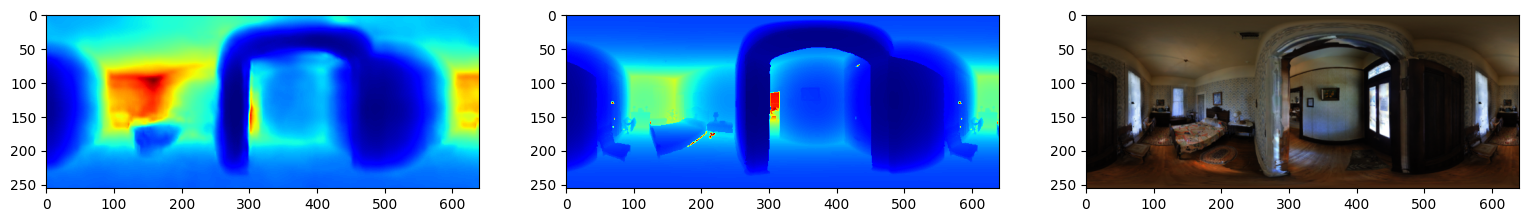

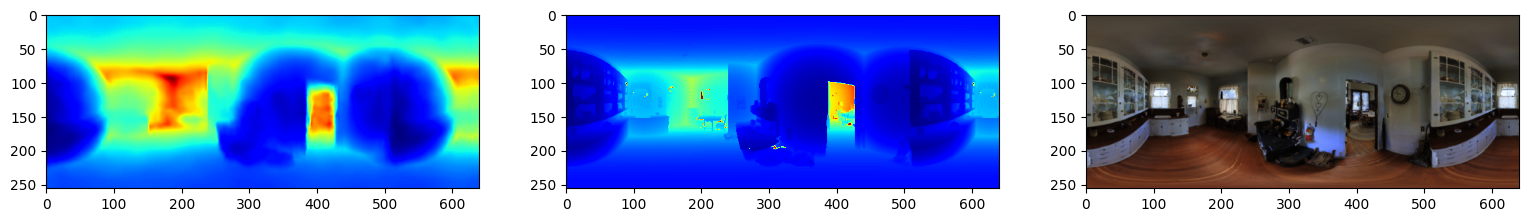

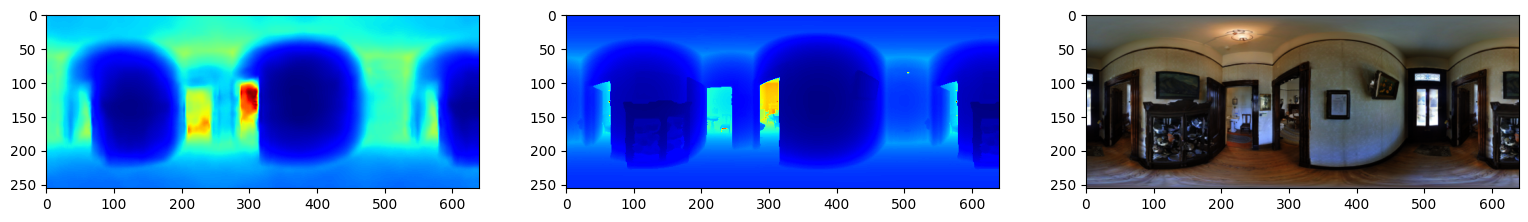

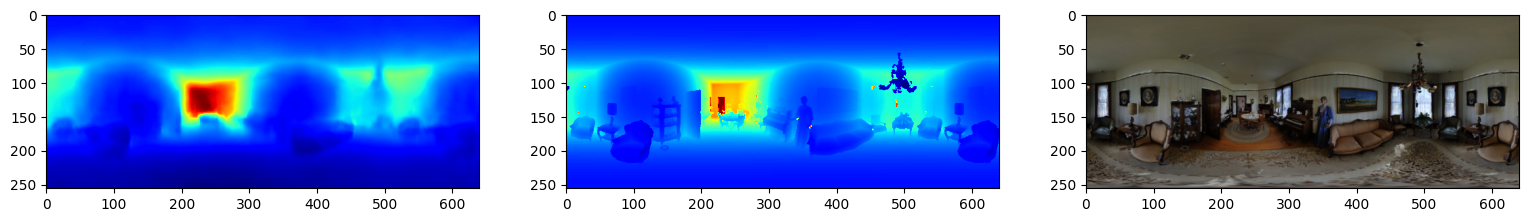

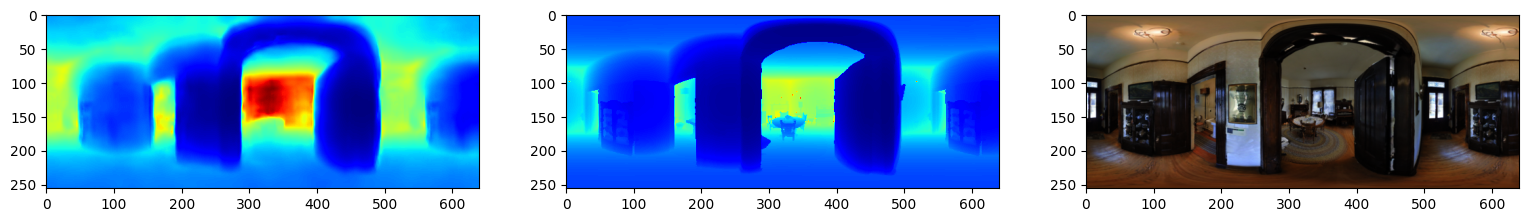

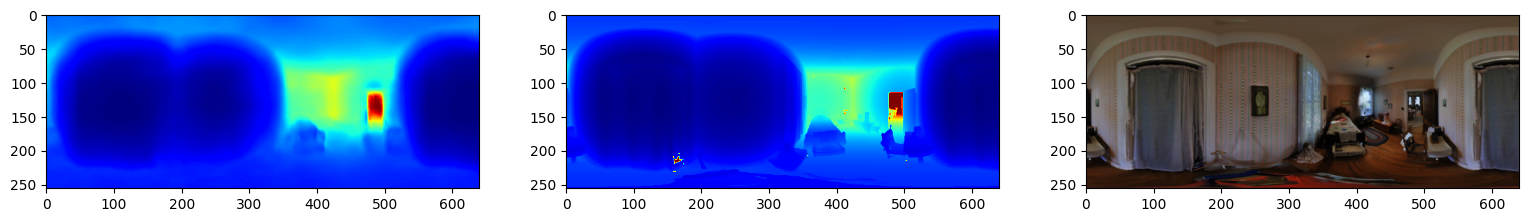

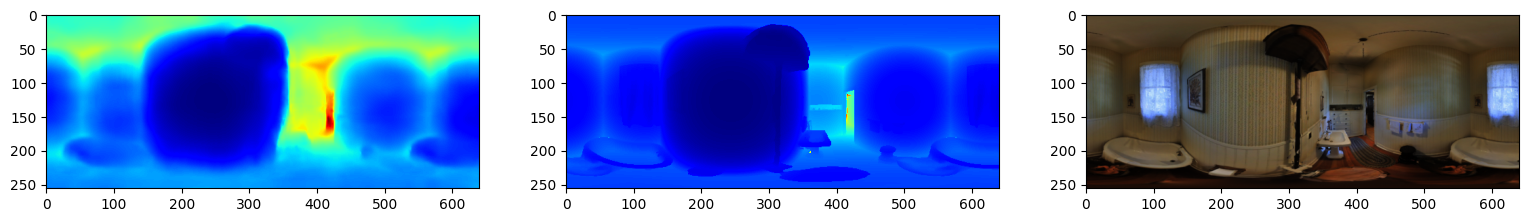

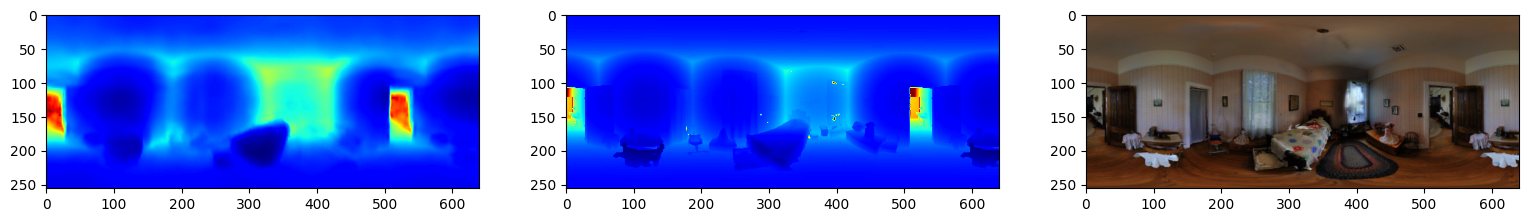

In [6]:
imgs, depths = test_generator[0]
preds = model.predict(imgs)
cmap = plt.cm.jet
cmap.set_bad(color='black')

for pred, depth, img in zip(preds[:20], depths[:20], imgs[:20]):
    start = time.time()
    print(time.time() - start)
    
    plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(pred.squeeze(), cmap=cmap)
    plt.subplot(1,3,2)
    plt.imshow(depth.squeeze(), cmap=cmap)
    plt.subplot(1,3,3)
    plt.imshow(img)

In [20]:
sess = onnxruntime.InferenceSession("mobile_scene_skip_loss_1.onnx", providers=["TensorrtExecutionProvider"])
calculate_errors_onnx(sess, test_generator)

  0%|          | 0/47 [00:00<?, ?it/s]

Abs Rel: 6.33 | Sq Rel: 0.73 | RMSE: 0.08 | RMSE log: 0.46 | a1: 0.55 | a2: 0.79 | a3: 0.88


(9671.546819970012,
 1111.1297269854695,
 115.24159144237638,
 709.0811808407307,
 846.2258850097645,
 1204.9180419921888,
 1347.8068359374997)

(32, 256, 640, 1)
4.291534423828125e-06
9.5367431640625e-07
1.430511474609375e-06
9.5367431640625e-07
1.1920928955078125e-06
9.5367431640625e-07
1.430511474609375e-06
1.1920928955078125e-06
1.1920928955078125e-06
1.1920928955078125e-06
1.430511474609375e-06
1.1920928955078125e-06
1.1920928955078125e-06
9.5367431640625e-07
9.5367431640625e-07
1.1920928955078125e-06
9.5367431640625e-07
9.5367431640625e-07
1.430511474609375e-06
1.430511474609375e-06


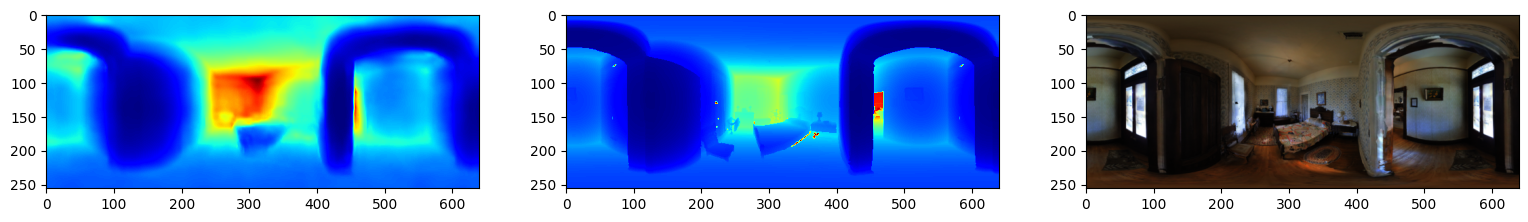

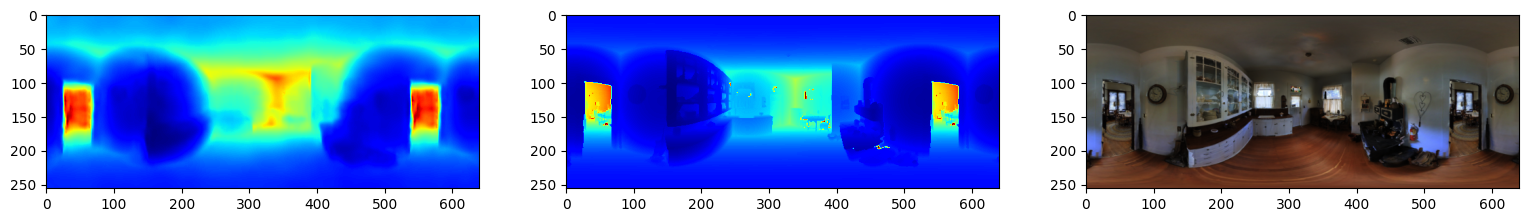

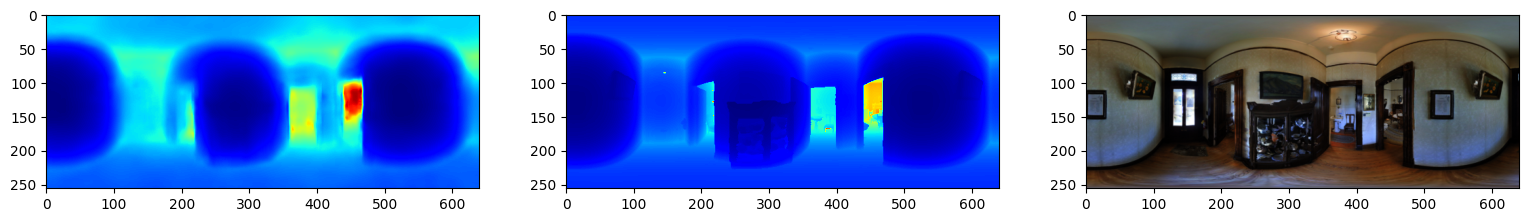

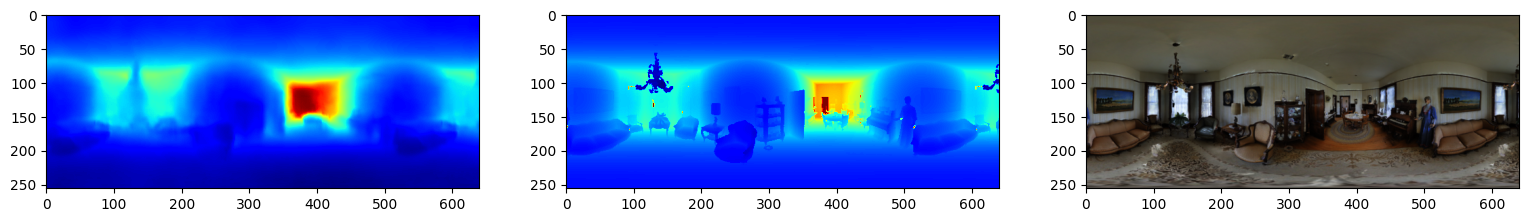

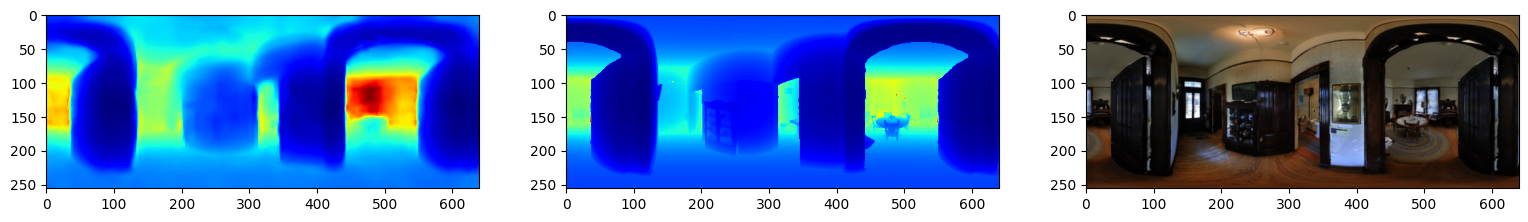

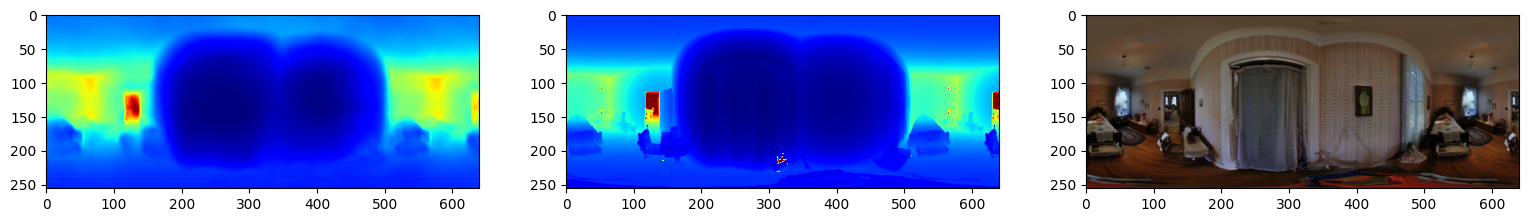

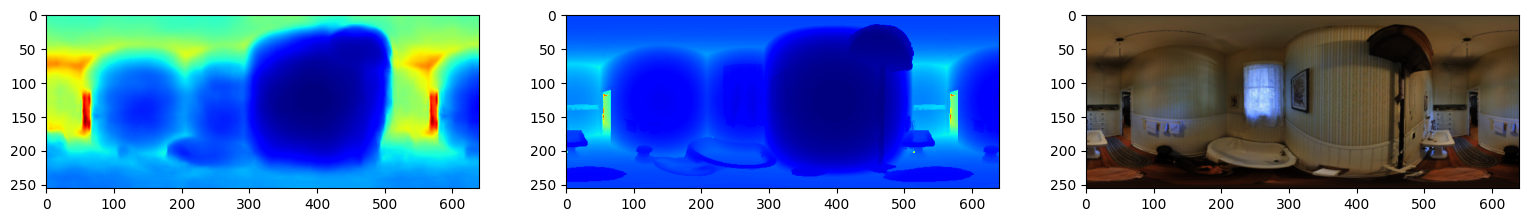

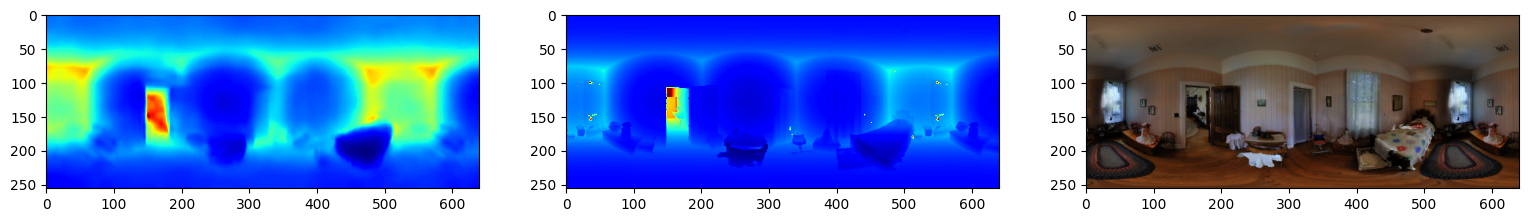

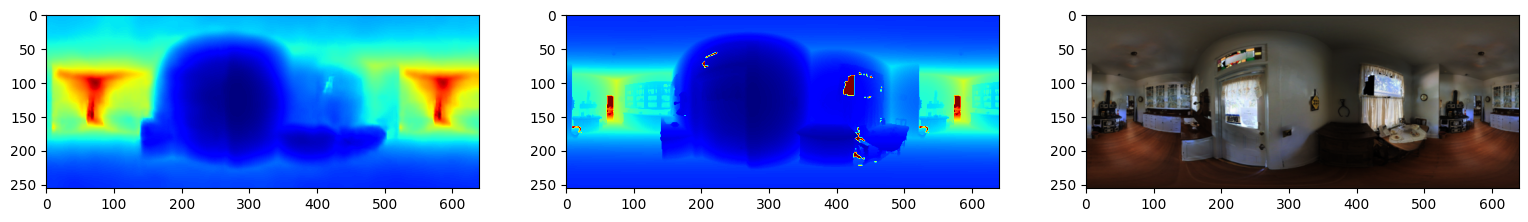

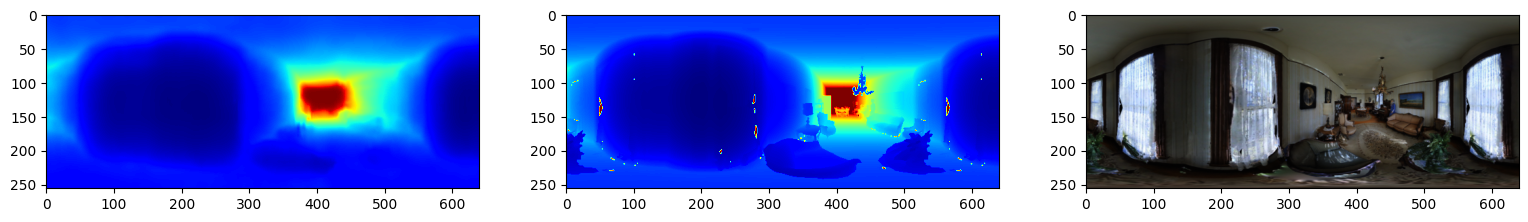

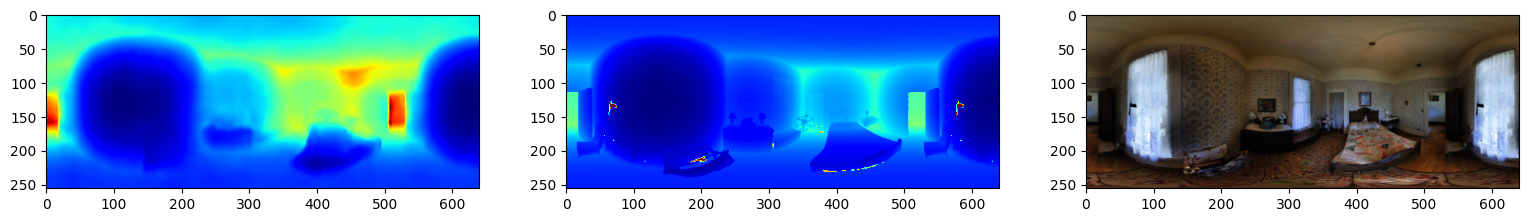

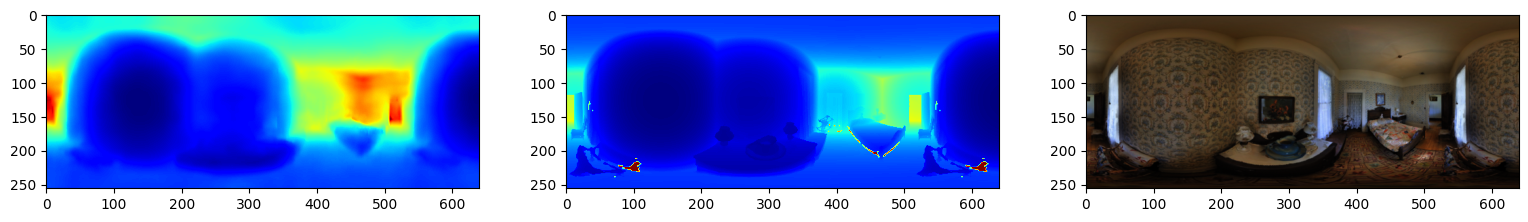

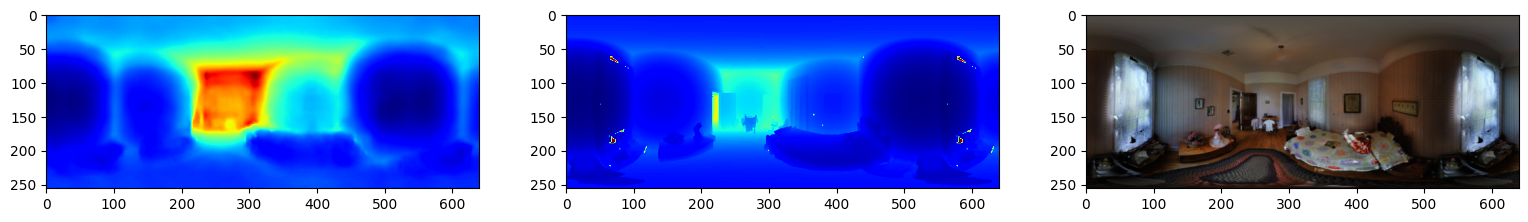

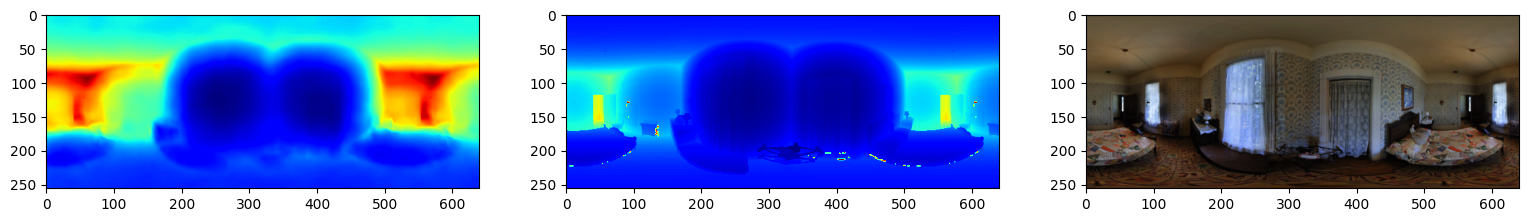

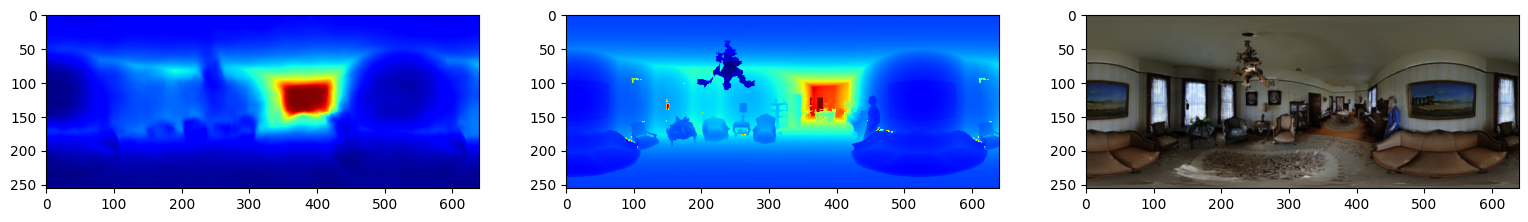

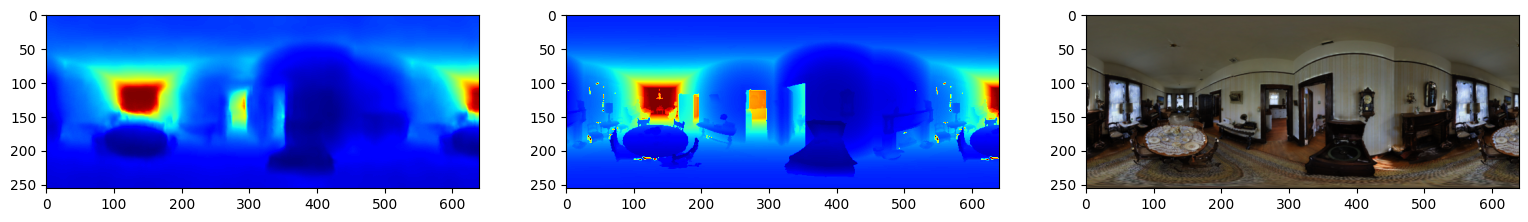

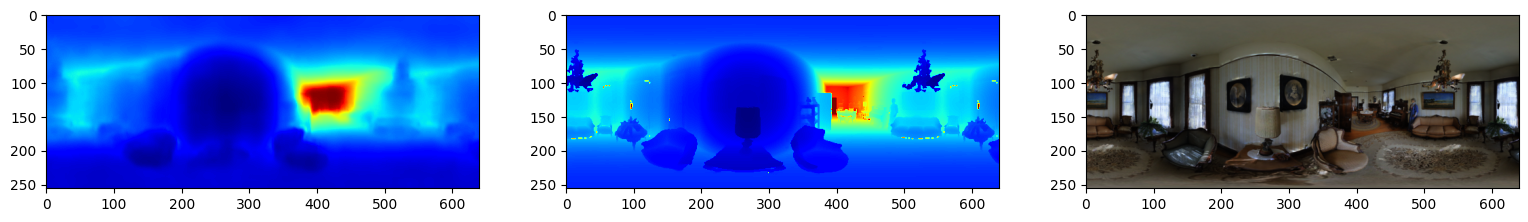

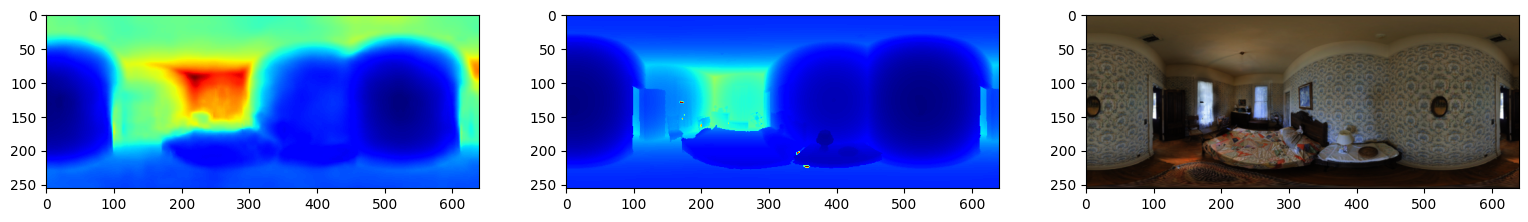

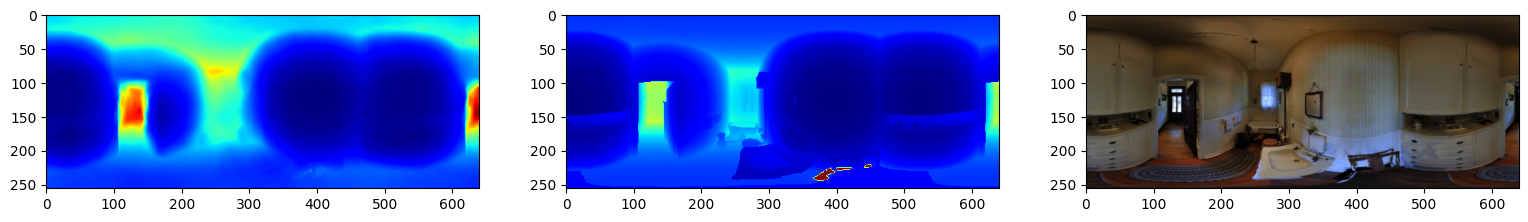

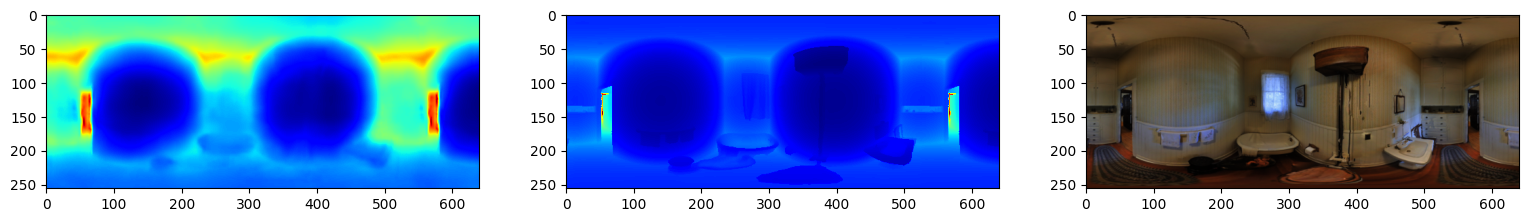

In [13]:
imgs, depths = test_generator[0]

inputs = sess.get_inputs()[0].name
output = sess.get_outputs()[0].name
preds = sess.run([output], {inputs: imgs})[0]
print(preds.shape)

cmap = plt.cm.jet
cmap.set_bad(color='black')

for pred, depth, img in zip(preds[:20], depths[:20], imgs[:20]):
    start = time.time()
    print(time.time() - start)
    
    plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(pred.squeeze(), cmap=cmap)
    plt.subplot(1,3,2)
    plt.imshow(depth.squeeze(), cmap=cmap)
    plt.subplot(1,3,3)
    plt.imshow(img)